Importing the basic necessary libraries that we will be using through out this project.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

$$\LARGE{\textbf{Task 1}}$$

The following SQL search for SDSS provides us the required flux data for H alpha, H beta, OI, OIII, NII, and SII, in additon to the corresponding redshift.
Note that to ensure that we get narrow line regions, we apply limits on velocity dispersion as Narrow lines have a smaller velocity dispersion compared to broad lines. Moreover, additionally we also apply an upper limit to FWHM.
Laslty, to ensure we don't end up dividing by zero at any stage, we only consider the Galazies where the flux is non-zero.
Finally, we order these objects by decreasing redshift for easy parsing through the files.

SELECT TOP 30000

s.plate,s.mjd, s.fiberid,
g.oiii_5007_flux, g.h_beta_flux, g.nii_6584_flux, 
g.sii_6717_flux, g.h_alpha_flux, g.sii_6731_flux, 
g.oi_6300_flux, g.h_alpha_eqw,s.z

FROM SpecObj AS s

JOIN GalSpecLine AS g ON

    s.specobjid = g.specobjid

WHERE

    s.z < 0.35
    AND s.class = 'Galaxy'
    -- For narrow line region we apply an upper limit on velocity dispersion
    AND g.oiii_sigma < 200 
    AND g.sigma_balmer*2.355<500
    AND g.oiii_5007_flux>0
    AND g.h_beta_flux>0
    AND  g.nii_6584_flux>0
    AND  g.sii_6717_flux>0
    AND  g.h_alpha_flux>0
    AND  g.sii_6731_flux>0
    AND  g.oi_6300_flux>0

ORDER BY

    s.z DESC

Once the files are read, we create the log of the ratios that we will be extensively needing through this task and save them as columns of the variable df.

In [2]:
df = pd.read_csv('task1.csv',header=0, index_col=0, skiprows=[0], usecols=[2,3,4,5,6,7,8,9,10,11])
df['log_nii_ha'] = np.log10(df['nii_6584_flux'] / df['h_alpha_flux'])
df['log_oiii_hb'] = np.log10(df['oiii_5007_flux'] / df['h_beta_flux'])
df.head()

,oiii_5007_flux,h_beta_flux,nii_6584_flux,sii_6717_flux,h_alpha_flux,sii_6731_flux,oi_6300_flux,h_alpha_eqw,z,log_nii_ha,log_oiii_hb
fiberid,,,,,,,,,,,
145,1.285353,14.640330,7.323015,4.497595,25.001010,9.409963,1.589461,-6.011693,0.349981,-0.533268,-1.056528
341,0.088316,1.294852,5.469841,4.854074,3.484172,2.140545,1238.440000,1.317540,0.349978,0.195875,-1.166180
55,1.905438,0.789994,3.575261,4.677557,10.522650,6.479507,9.789614,0.677702,0.349959,-0.468817,0.382371
536,5.607070,20.733130,38.880390,12.123580,96.095150,12.777610,1.717490,-48.364940,0.349927,-0.392971,-0.567929
6,2.028834,1.894922,4.797323,0.698066,0.265611,1.371674,1.693157,2.654131,0.349908,1.256753,0.029655


We define the two curve functions.

In [3]:
def kewley01(x):
    return 0.61 / (x - 0.47) + 1.19

def kauffmann03(x):
    return 0.61 / (x - 0.05) + 1.3

In order to not repeat the plotting process multiple times, we define a function that takes in the respective data and creates the respective plots. To ensure that we have different titles if different data is plotted, the function also takes in the arguments for the respective titles, whilst the default title being "BPT Diagram".

In [4]:
def plotty(df, title="BPT Diagram", xtitle=r'$\log([NII]/ H\alpha)$',ytitle=r'$\log([OIII] / H\beta)$'):
    x = np.linspace(-1.5, 0.3, 400)
    x2 = np.linspace(-1.5, 0, 320)

    df['kewley'] = kewley01(df['log_nii_ha'])
    df.loc[df['log_nii_ha'] < 0, 'kauffmann'] = kauffmann03(df.loc[df['log_nii_ha'] < 0, 'log_nii_ha'])

    below_kauffmann = df['log_oiii_hb'] < df['kauffmann']
    between_kauffmann_kewley = (df['log_oiii_hb'] >= df['kauffmann']) & (df['log_oiii_hb'] < df['kewley'])
    above_kewley = df['log_oiii_hb'] >= df['kewley']

    plt.figure( figsize=(10, 8))

    plt.scatter(df[below_kauffmann]['log_nii_ha'], df[below_kauffmann]['log_oiii_hb'], s=3, alpha=0.5, color='blue', label='Star-forming')
    plt.scatter(df[between_kauffmann_kewley]['log_nii_ha'], df[between_kauffmann_kewley]['log_oiii_hb'], s=3, alpha=0.5, color='gray', label='Composite')
    plt.scatter(df[above_kewley]['log_nii_ha'], df[above_kewley]['log_oiii_hb'], s=3, alpha=0.5, color='red', label='AGN')

    # Plot division lines
    plt.plot(x, kewley01(x), 'r--', label='Kewley et al. (2001)')
    plt.plot(x2, kauffmann03(x2), 'b-', label='Kauffmann et al. (2003)')

    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.legend()
    plt.xlim(-2,0.5)
    plt.ylim(-1,1.5)
    plt.title(title)
    plt.show()

It can be seen how the function separates the AGNs from Star-forming and Composite regions.

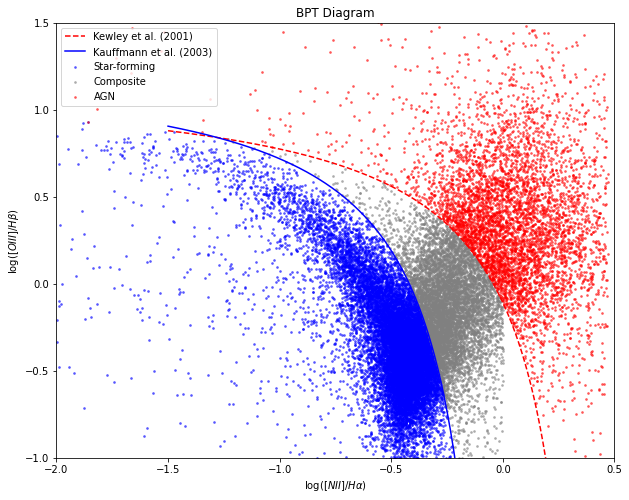

In [5]:
plotty(df)

For (b), we define the redshift bins. I noticed that 0<z<0.10 was not providing us with any appreciable data points and hence got rid of those redshift bins

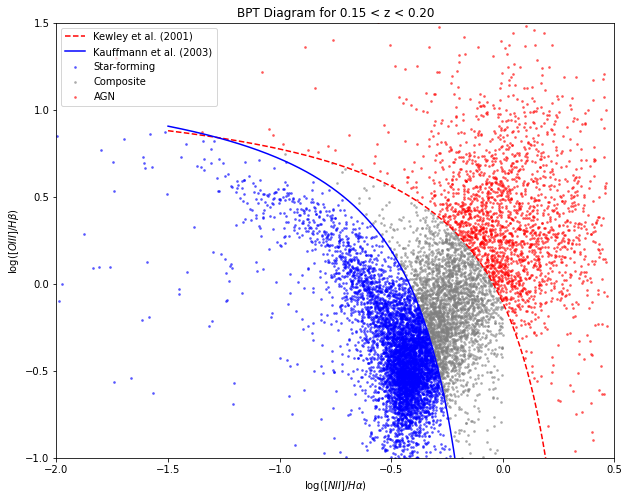

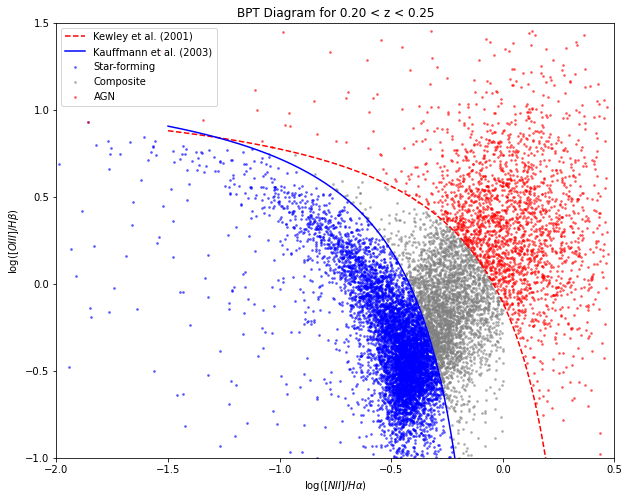

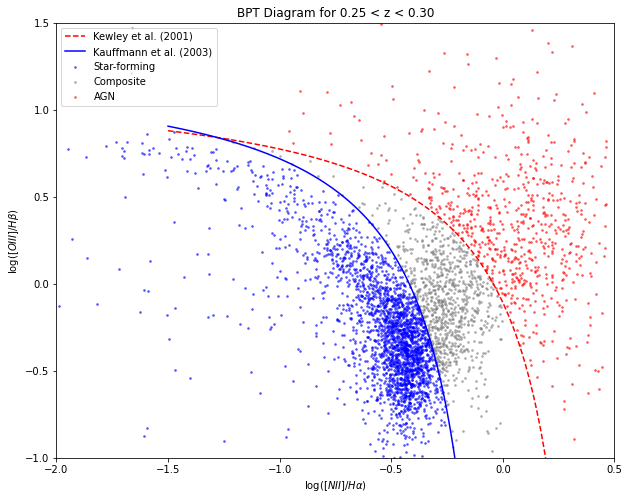

In [6]:
redshift_bins = np.arange(0.15, 0.35, 0.05)

for i in range(len(redshift_bins) - 1):
    z_min = redshift_bins[i]
    z_max = redshift_bins[i + 1]
    
    bin_data = df[(df['z'] >= z_min) & (df['z'] < z_max)].copy()  # Create a copy of the slice

    plotty(bin_data,f'BPT Diagram for {z_min:.2f} < z < {z_max:.2f}')

Yes, there was barely any population in the 0<z<0.15 region. 0.20<z<0.25 seems most populated while 0.30<z<0.35 is sparsely populated as well. 

Moreover, we can use S/N ratio for galaxies to present and compare different distributions.

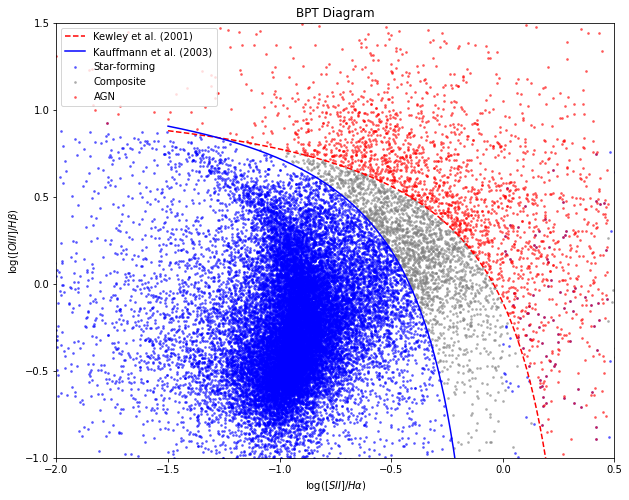

In [7]:
df['log_nii_ha'] = np.log10(df['sii_6731_flux'] / df['h_alpha_flux'])
df['log_oiii_hb'] = np.log10(df['oiii_5007_flux'] / df['h_beta_flux'])
plotty(df,xtitle=r'$\log([SII]/ H\alpha)$')

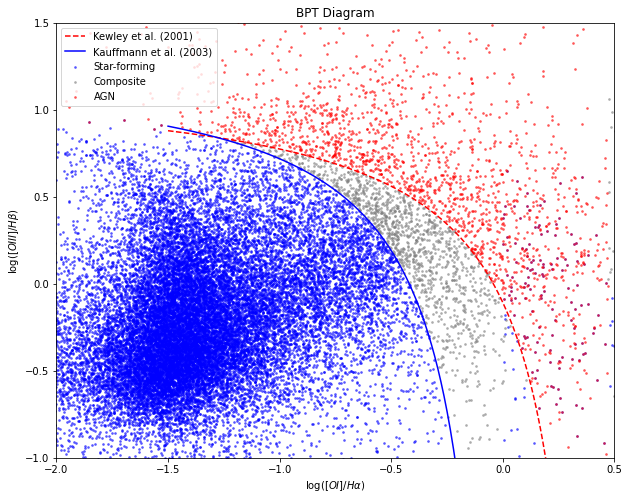

In [8]:
df['log_nii_ha'] = np.log10(df['oi_6300_flux'] / df['h_alpha_flux'])
df['log_oiii_hb'] = np.log10(df['oiii_5007_flux'] / df['h_beta_flux'])
plotty(df,xtitle=r'$\log([OI]/ H\alpha)$')

In [9]:
df['kewley'] = kewley01(df['log_nii_ha'])
above_kewley = df[df['log_oiii_hb'] >= df['kewley']]
print(f"The number of Seyfert galaxies is {len(above_kewley)}")

The number of Seyfert galaxies is 1802


For task (d), I struggled with the WHAN diagram. Unless there is something wrong with my SQL query, I cannot seem to make sense of the LOG[W_H beta] vs LOG[NII/H alpha] plot. 
It must be observed that the corresponding program is applied theoretically accurately and it distinguishes the 5 types of regions, based on their NII to H alpha ratio and Equivalent Width of H beta. However, the patterns of galaxies does not match that of a traiditional WHAN.

Pure_Star_Forming_Galaxies: Filters galaxies with log([NII]/Hα) < -0.4 and |WHα| > 3.

Strong_AGN: Filters galaxies with log([NII]/Hα) > -0.4 and |WHα| > 6.

Weak_AGN: Filters galaxies with log([NII]/Hα) > -0.4, 3 < |WHα| < 6.

RGs: Filters galaxies with |WHα| < 3.

Passive_Galaxies: Filters galaxies with |WHα| < 0.5.

Possible corrections: I may either have struggled with the logarithm values of either of the two axes, or feeding the program incorrect data points and hence correcting this issue must produce the WHAN diagram as we expect.

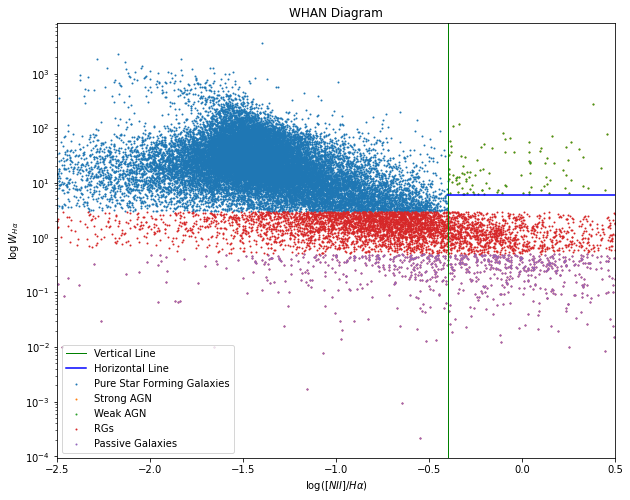

In [10]:
plt.figure( figsize=(10, 8))

# plt.scatter(df['log_nii_ha'],(abs(df['h_alpha_eqw'])),s=3)

plt.axvline(x=-0.4, color='g', linestyle='-', linewidth=1, label='Vertical Line')
# plt.axhline(y=0.5, color='b', linestyle='--', linewidth=1, label='Horizontal Line')
plt.plot([-0.4, 5], [6, 6], 'b-', label='Horizontal Line')

Pure_Star_Forming_Galaxies = df[(df['log_nii_ha'] < -0.4) & (np.abs(df['h_alpha_eqw']) > 3)]
Strong_AGN= df[(df['log_nii_ha'] > -0.4) & (np.abs(df['h_alpha_eqw']) > 6)]
Weak_AGN= df[(df['log_nii_ha'] > -0.4) & (np.abs(df['h_alpha_eqw'])) > 3 & (np.abs(df['h_alpha_eqw']) < 6 )]
RGs= df[(np.abs(df['h_alpha_eqw']) < 3)]
Passive_Galaxies=df[(np.abs(df['h_alpha_eqw']) < 0.5)]

labels=["Pure Star Forming Galaxies","Strong AGN","Weak AGN","RGs","Passive Galaxies"]
j=0
for i in [Pure_Star_Forming_Galaxies,Strong_AGN,Weak_AGN,RGs,Passive_Galaxies]:
    plt.scatter(i['log_nii_ha'],(abs(i['h_alpha_eqw'])),s=1, label=labels[j])
    j+=1

plt.yscale('log')
plt.xlabel(r'$\log([NII]/ H\alpha)$')
plt.ylabel(r'$\log W_{H\alpha}$')
plt.legend()
plt.xlim(-2.5,0.5)
# plt.ylim(0,100)
plt.title("WHAN Diagram")
plt.show()

In [11]:
print(f"Percentage of galaxies classified by BPT as Seyferts is {len(above_kewley)/300}%")
print(f"Percentage of galaxies classified by WHAN as Seyferts is {len(Strong_AGN)/300}%")

Percentage of galaxies classified by BPT as Seyferts is 6.006666666666667%
Percentage of galaxies classified by WHAN as Seyferts is 0.5033333333333333%


$$\LARGE{\textbf{Task 3}}$$

Once again, for task 3 we used the same filters as for task 1 to obtain our galaxies. However, one notable difference is that instead of selecting only the top 30,000 results, I obtained the maximum number of results that SDSS could provide me with.

The corresponding filters have stayed the same as above.

SELECT
    s.fiberid,

    W.w1flux,

    W.w2flux,

    W.w3flux,

    W.w1mpro,  -- WISE magnitude in W1 band

    W.w2mpro,  -- WISE magnitude in W2 band

    W.w3mpro,  -- WISE magnitude in W3 band
    
    s.z

FROM wise_xmatch AS X

    JOIN wise_allsky AS W ON X.wise_cntr = W.cntr
    JOIN SpecObj AS s ON X.sdss_objid = s.bestobjid
    JOIN GalSpecLine AS g ON s.specobjid = g.specobjid
WHERE

    s.z < 0.35
    AND s.class = 'Galaxy'
    AND g.oiii_sigma < 200
    AND g.sigma_balmer*2.355<500
    AND g.oiii_5007_flux > 0
    AND g.h_beta_flux > 0
    AND g.nii_6584_flux > 0
    AND g.sii_6717_flux > 0
    AND g.h_alpha_flux > 0
    AND g.sii_6731_flux > 0
    AND g.oi_6300_flux > 0
ORDER BY

    s.z DESC


We once again define columns of data that we will need for the rest of this task. This includes the differences of WISE Magnitudes as well as the corresponding logarithmic ratios.

In [12]:
df = pd.read_csv('task3.csv',header=0, index_col=0, skiprows=[0], usecols=[0,1,2,3,4,5,6])
df['w1_w2'] = df['w1mpro'] - df['w2mpro']
df['w2_w3'] = df['w2mpro'] - df['w3mpro']

x = np.log10(df['w3flux'] / df['w2flux'])
y = np.log10(df['w2flux'] / df['w1flux'])

df = df.dropna()
df.head()

/Users/iammhaiderkhan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,w1flux,w2flux,w3flux,w1mpro,w2mpro,w3mpro,w1_w2,w2_w3
fiberid,,,,,,,,
145,145.860,80.646,131.910,15.090,14.734,11.923,0.356,2.811
341,154.600,79.524,90.465,15.027,14.749,12.112,0.278,2.637
55,196.230,103.190,98.526,14.768,14.466,12.049,0.302,2.417
536,34.511,21.585,126.950,16.655,16.165,12.741,0.490,3.424
6,252.770,120.130,-17.272,14.493,14.301,12.694,0.192,1.607


The following functions define the upper, lower and left limits for the Seyfert galaxies.

In [13]:
def top_boundary(x):
    return 0.315 * x + 0.297

def bottom_boundary(x):
    return 0.315 * x - 0.110

def left_limit(x):
    return -3.172 * x + 0.436

The variable 'dff' encapsulates the data points that lie within our limits: the Seyfert galaxies.

In [14]:
dff=[]
for i in np.array(df):
    if i[-2]<=top_boundary(i[-2]) and i[-2]>=bottom_boundary(i[-2]) and i[-1]>left_limit(i[-1]):
        dff.append(i)

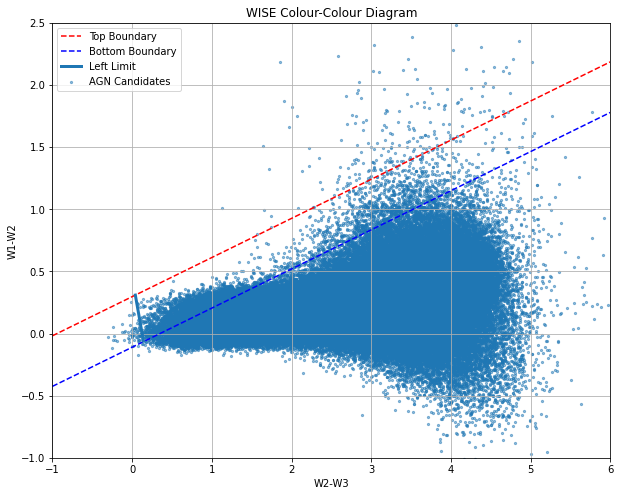

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(df['w2_w3'], df['w1_w2'], s=5, alpha=0.5, label='AGN Candidates')
# plt.scatter(df['w2_w3'], df['w1_w2'], s=5, alpha=0.5, label='AGN Candidates')


x_vals = np.linspace(-1, 6, 1000)
plt.plot(x_vals, top_boundary(x_vals), 'r--', label='Top Boundary')
plt.plot(x_vals, bottom_boundary(x_vals), 'b--', label='Bottom Boundary')
plt.plot([139/3487,546/3847],[134928/435875,-10579/174350], label='Left Limit', linewidth=3)

plt.xlim(-1,6)
plt.ylim(-1,2.5)

# plt.xlabel(r'$\log_{10}(W3/W2)})$')
# plt.ylabel(r'$\log_{10}(W2/W1)$')
plt.xlabel('W2-W3')
plt.ylabel('W1-W2')

plt.title('WISE Colour-Colour Diagram')
plt.legend()
plt.grid()
plt.show()

In [16]:
print(f'The number of AGNs found using the WISE Color-Color Diagram is {len(dff)}.')

The number of AGNs found using the WISE Color-Color Diagram is 409717.


In the following cell, we cross-match our data points from task 3 with those from task 1.
First we compare the fiber ID and redshift of all the datapoints in the SDSS data to find out how many of those are present in the WISE data.
Following that, we filter out only those objects that both WISE color color and BPT diagrams classify as AGNs.

In [17]:
dff = pd.read_csv('task3.csv',header=0, index_col=0, skiprows=[0])
df2 = pd.read_csv('task1.csv',header=0, index_col=0, skiprows=[0])
df2['log_nii_ha'] = np.log10(df2['nii_6584_flux'] / df2['h_alpha_flux'])
df2['log_oiii_hb'] = np.log10(df2['oiii_5007_flux'] / df2['h_beta_flux'])
def kewley01(x):
    return 0.61 / (x - 0.47) + 1.19
df2['kewley'] = kewley01(df2['log_nii_ha'])
above_kewley = df2[df2['log_oiii_hb'] >= df2['kewley']]

In [18]:
matched_df = pd.merge(dff, df2[['fiberid', 'z']], on=['fiberid', 'z'], how='inner')
print(f'The number of objects found in both WISE and SDSS data is {len(matched_df)}.')
matched_df = pd.merge(dff, above_kewley[['fiberid', 'z']], on=['fiberid', 'z'], how='inner')
print(f'The number of AGN objects found in both WISE and SDSS data is {len(matched_df)}.')

The number of objects found in both WISE and SDSS data is 28575.
The number of AGN objects found in both WISE and SDSS data is 5354.


$$\LARGE{\textbf{Task 4}}$$

Preprocessing first:

We import the QNPy and preprocessing librarires.

In [19]:
import QNPy #Importing the package

from QNPy import Preprocess as pr #Importing Preprocess module from the package
from QNPy.Preprocess import transform #importing the funcion transform for transformation the data
from QNPy.Preprocess import * #importing all external packages from Preprocess

Defining the path to the light curves data. I have a folder named 'light curves' in my directory that contains the light curves data for 10 QSOs. 

In [20]:
path = './light_curves' #path to data
csv_files = glob.glob(path + "/*.csv")
df_list = (pd.read_csv(file) for file in csv_files)
data = pd.concat(df_list, ignore_index=True)

The following code defines the paths to the data folder and the folder where the results will be saved.

In [21]:
input_folder = './light_curves'
output_folder = './light_curves_clean'
threshold = 3.0

outliers=pr.clean_and_save_outliers(input_folder, output_folder, threshold=threshold)

Cleaned and saved 3152786.csv to ./light_curves_clean/3152786.csv
Cleaned and saved 2524327.csv to ./light_curves_clean/2524327.csv
Cleaned and saved 3102202.csv to ./light_curves_clean/3102202.csv
Cleaned and saved 3104329.csv to ./light_curves_clean/3104329.csv
Cleaned and saved 3097526.csv to ./light_curves_clean/3097526.csv
Cleaned and saved 2473812.csv to ./light_curves_clean/2473812.csv
Cleaned and saved 3844725.csv to ./light_curves_clean/3844725.csv
Cleaned and saved 3078106.csv to ./light_curves_clean/3078106.csv
Cleaned and saved 3032591.csv to ./light_curves_clean/3032591.csv
Cleaned and saved 2579983.csv to ./light_curves_clean/2579983.csv


In [22]:
input_folder = './light_curves'
output_folder = './light_curves_clean'
threshold_aggregation = 5
threshold_outliers = 3.0

outliers=pr.clean_save_aggregate_data(input_folder, output_folder, threshold_aggregation, threshold_outliers)

Cleaned and saved 3152786.csv to ./light_curves_clean/3152786.csv
Cleaned and saved 2524327.csv to ./light_curves_clean/2524327.csv
Cleaned and saved 3102202.csv to ./light_curves_clean/3102202.csv
Cleaned and saved 3104329.csv to ./light_curves_clean/3104329.csv
Cleaned and saved 3097526.csv to ./light_curves_clean/3097526.csv
Cleaned and saved 2473812.csv to ./light_curves_clean/2473812.csv
Cleaned and saved 3844725.csv to ./light_curves_clean/3844725.csv
Cleaned and saved 3078106.csv to ./light_curves_clean/3078106.csv
Cleaned and saved 3032591.csv to ./light_curves_clean/3032591.csv
Cleaned and saved 2579983.csv to ./light_curves_clean/2579983.csv
Processing completed.


In [23]:
padding= pr.backward_pad_curves('./light_curves', './Padded_lc', desired_observations=100)

Created new file: ./Padded_lc/3152786.csv
Created new file: ./Padded_lc/2524327.csv
Created new file: ./Padded_lc/3102202.csv
Created new file: ./Padded_lc/3104329.csv
Created new file: ./Padded_lc/3097526.csv
Created new file: ./Padded_lc/2473812.csv
Created new file: ./Padded_lc/3844725.csv
Created new file: ./Padded_lc/3078106.csv
Created new file: ./Padded_lc/3032591.csv
Created new file: ./Padded_lc/2579983.csv


In [24]:
#Path to Padded Data
DATA_SRC = "./Padded_lc" 
#path to folder to save preproc data (transformed data) + errors
DATA_DST = "./preproc" 

In [25]:
files = os.listdir(DATA_SRC) 

In [26]:
number_of_points, trcoeff = pr.transform_and_save(files, DATA_SRC, DATA_DST, transform)

Splitting the Data

In [27]:
from QNPy import SPLITTING_AND_TRAINING as st #Importing SPLITTING_AND_TRAINING module from the package
from QNPy.SPLITTING_AND_TRAINING import * #Importing all packages from SPLITTING_AND_TRAINING module

In [28]:
DATA_SRC = "./preproc" #Path to transformed data
files = os.listdir(DATA_SRC) #listing the transformed data
st.create_split_folders(train_folder='."/dataset/train/', test_folder='./dataset/test/', val_folder='./dataset/val/')
TRAIN_FOLDER = './dataset/train/'
TEST_FOLDER = './dataset/test/'
VAL_FOLDER = './dataset/val/'
st.split_data(files, DATA_SRC, TRAIN_FOLDER, TEST_FOLDER, VAL_FOLDER) 

100%|██████████| 30/30 [00:00<00:00, 342.68it/s]


Training the Data

In [29]:
DATA_PATH_TRAIN = "./dataset/train" #path to train folder
DATA_PATH_VAL = "./dataset/val" #path to val folder

MODEL_PATH = "./output/cnp_model.pth" #path for saving modelx

In [30]:
BATCH_SIZE=32 #Defining the batch size, it should remain 32
trainLoader, valLoader = st.get_data_loaders(DATA_PATH_TRAIN, DATA_PATH_VAL, BATCH_SIZE) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device
model, optimizer, criterion, mseMetric, maeMetric = st.create_model_and_optimizer(device) 

In [31]:
#function for training the data
# numbers that we give in this example are: 
#1 - number of train_model function runs
#3000 - number of epochs
#2000 - number of early stopping limit
# These numbers are optional and can be changed as needed.
history_loss_train, history_loss_val, \
history_mse_train, history_mse_val, \
history_mae_train, history_mae_val, \
epoch_counter_train_loss, epoch_counter_train_mse, \
epoch_counter_train_mae, epoch_counter_val_loss, \
epoch_counter_val_mse, epoch_counter_val_mae = st.train_model(
    model, trainLoader, valLoader, criterion, optimizer, 1, 1000, 500, mseMetric, maeMetric, device)

100%|██████████| 1000/1000 [02:07<00:00,  7.86it/s]


In [32]:
file_names = ["history_loss_train.csv", "history_loss_val.csv", "history_mse_train.csv", "history_mse_val.csv",
              "history_mae_train.csv", "history_mae_val.csv", "epoch_counter_train_loss.csv",
              "epoch_counter_train_mse.csv", "epoch_counter_train_mae.csv", "epoch_counter_val_loss.csv",
              "epoch_counter_val_mse.csv", "epoch_counter_val_mae.csv"]

# Define the lists
lists = [history_loss_train, history_loss_val, history_mse_train, history_mse_val, history_mae_train,
         history_mae_val, epoch_counter_train_loss, epoch_counter_train_mse, epoch_counter_train_mae,
         epoch_counter_val_loss, epoch_counter_val_mse, epoch_counter_val_mae]

In [33]:
#running the function for saving all lists with histories
save_list= st.save_lists_to_csv(file_names, lists)
# Replace with the path to your history_loss_train CSV file
history_loss_train_file = './history_loss_train.csv'  
# Replace with the path to your history_loss_val CSV file
history_loss_val_file = './history_loss_val.csv'  
# Replace with the path to your epoch_counter_train_loss CSV file
epoch_counter_train_loss_file = './epoch_counter_train_loss.csv' 

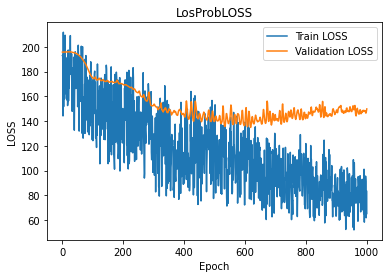

In [34]:
logprobloss=st.plot_loss(history_loss_train_file, history_loss_val_file, epoch_counter_train_loss_file)

In [35]:
 # Replace with the path to your history_mse_train CSV file
history_mse_train_file = './history_mse_train.csv'
# Replace with the path to your history_mse_val CSV file
history_mse_val_file = './history_mse_val.csv'  
# Replace with the path to your epoch_counter_train_mse CSV file
epoch_counter_train_mse_file = './epoch_counter_train_mse.csv'  

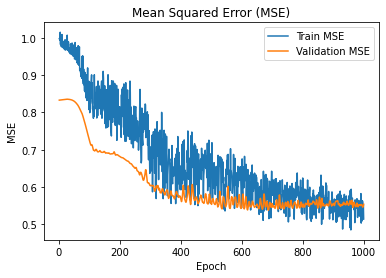

In [36]:
msemetric=st.plot_mse(history_mse_train_file, history_mse_val_file, epoch_counter_train_mse_file)

In [37]:
# Replace with the path to your history_mae_train CSV file
history_mae_train_file = './history_mae_train.csv'
# Replace with the path to your history_mae_val CSV file
history_mae_val_file = './history_mae_val.csv'  
# Replace with the path to your epoch_counter_train_mae CSV file
epoch_counter_train_mae_file = './epoch_counter_train_mae.csv'  

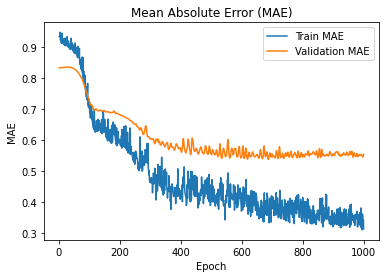

In [38]:
#plotting the MAE metric after training
maemetric=st.plot_mae(history_mae_train_file, history_mae_val_file, epoch_counter_train_mae_file)

In [39]:
save=st.save_model(model, MODEL_PATH)#saving the trained model

Prediction

In [40]:
from QNPy import PREDICTION as prd #Importing PREDICTION module from the package
from QNPy.PREDICTION import * #Importing all packages from PREDICTION module
from QNPy.PREDICTION import plot_function #The functions plot_function must be imported separately

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [42]:
prd.create_prediction_folders()

Folder already exists: ./output/predictions/train
Folder already exists: ./output/predictions/train/plots
Folder already exists: ./output/predictions/train/data
Folder already exists: ./output/predictions/test
Folder already exists: ./output/predictions/test/plots
Folder already exists: ./output/predictions/test/data
Folder already exists: ./output/predictions/val
Folder already exists: ./output/predictions/val/plots
Folder already exists: ./output/predictions/val/data


In [43]:
DATA_PATH_TRAIN = "./dataset/train" #path to train folder
DATA_PATH_VAL = "./dataset/val" #path to val folder
DATA_PATH_TEST="./dataset/test" #path to test folder
OUTPUT_PATH = "./output/predictions" #path where to save the plots and data

MODEL_PATH = "./output/cnp_model.pth" #path to saved model

In [44]:
prd.prepare_output_dir(OUTPUT_PATH)#clearing outputh dir, it can be sciped
model = prd.load_trained_model(MODEL_PATH, device) #loading the model
criterion, mseMetric= prd.get_criteria()#loading criterion and metrics from model
folder_path = "./dataset/test"  # Change this to your dataset folder

prd.remove_padded_values_and_filter(folder_path)


Deleted file with 'minus' or 'plus' in the name: 3844725_minus_split22.csv
Removed padding in file: 2524327_original_split0.csv
Deleted file with 'minus' or 'plus' in the name: 3844725_plus_split18.csv


In [45]:
folder_path = "./dataset/train"  # Change this to your dataset folder

prd.remove_padded_values_and_filter(folder_path)

Deleted file with 'minus' or 'plus' in the name: 2473812_plus_split23.csv
Deleted file with 'minus' or 'plus' in the name: 3104329_plus_split26.csv
Removed padding in file: 3102202_original_split3.csv
Deleted file with 'minus' or 'plus' in the name: 3104329_minus_split5.csv
Removed padding in file: 3032591_original_split15.csv
Deleted file with 'minus' or 'plus' in the name: 3097526_plus_split24.csv
Deleted file with 'minus' or 'plus' in the name: 2473812_minus_split1.csv
Removed padding in file: 3097526_original_split9.csv
Removed padding in file: 3152786_original_split13.csv
Removed padding in file: 3078106_original_split20.csv
Deleted file with 'minus' or 'plus' in the name: 3032591_plus_split21.csv
Removed padding in file: 2579983_original_split11.csv
Deleted file with 'minus' or 'plus' in the name: 3102202_minus_split25.csv
Removed padding in file: 2473812_original_split27.csv
Removed padding in file: 3844725_original_split7.csv
Deleted file with 'minus' or 'plus' in the name: 303

In [46]:
folder_path = "./dataset/val"  # Change this to your dataset folder

prd.remove_padded_values_and_filter(folder_path)

Deleted file with 'minus' or 'plus' in the name: 3152786_minus_split17.csv
Deleted file with 'minus' or 'plus' in the name: 2524327_plus_split29.csv
Deleted file with 'minus' or 'plus' in the name: 3078106_minus_split16.csv
Deleted file with 'minus' or 'plus' in the name: 3102202_plus_split19.csv
Deleted file with 'minus' or 'plus' in the name: 3097526_minus_split10.csv
Removed padding in file: 3104329_original_split28.csv


In [47]:
testLoader=prd.load_test_data(DATA_PATH_TEST)#loading test data
trainLoader=prd.load_train_data(DATA_PATH_TRAIN)#loading trained data
valLoader=prd.load_val_data(DATA_PATH_VAL)#loading validation data
testMetrics=prd.plot_light_curves_from_test_set(model, testLoader, criterion, mseMetric, plot_function, device)
saveTestMetric=prd.save_test_metrics('./output/predictions/', testMetrics)#saving the test Metrics

100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


<Figure size 432x288 with 0 Axes>

In [48]:
#prediction and plotting the train data
trainMetrics=prd.plot_light_curves_from_train_set(trainLoader, model, criterion, mseMetric, plot_function, device)
saveTrainMetric=prd.save_train_metrics('./output/predictions/', trainMetrics)#saving the train metrics 

100%|██████████| 8/8 [00:01<00:00,  6.68it/s]


<Figure size 432x288 with 0 Axes>

In [49]:
#prediction and plotting the val data
valMetric=prd.plot_light_curves_from_val_set(model, valLoader, criterion, mseMetric, plot_function, device)
saveValMetrics=prd.save_val_metrics('./output/predictions/', valMetric)#saving the val metrics 

100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


<Figure size 432x288 with 0 Axes>